In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage

In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    #shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [27]:
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegranate_healthy']

In [63]:
# for image_batch, labels_batch in dataset.take(1):
#     #print(image_batch.shape)
#     #print(labels_batch.numpy())
    
#     for i in range(12):
#         ax = plt.subplot(3,4,i+1)
        
#         #plt.imshow(image_batch[i].numpy().astype("uint8"))
        
#         def rgb2gray(rgb):
#             return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
        
        
#         img_gray = rgb2gray(image_batch[i])
        
#         def apply_gaussian_blur(img_gray):
#             blurred_image = tf.image.gaussian_filter2d(image, sigma=1.0)
#             return blurred_image
        
#         plt.imshow(img_gray, cmap=plt.get_cmap('gray'))
#         #plt.show()
        
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

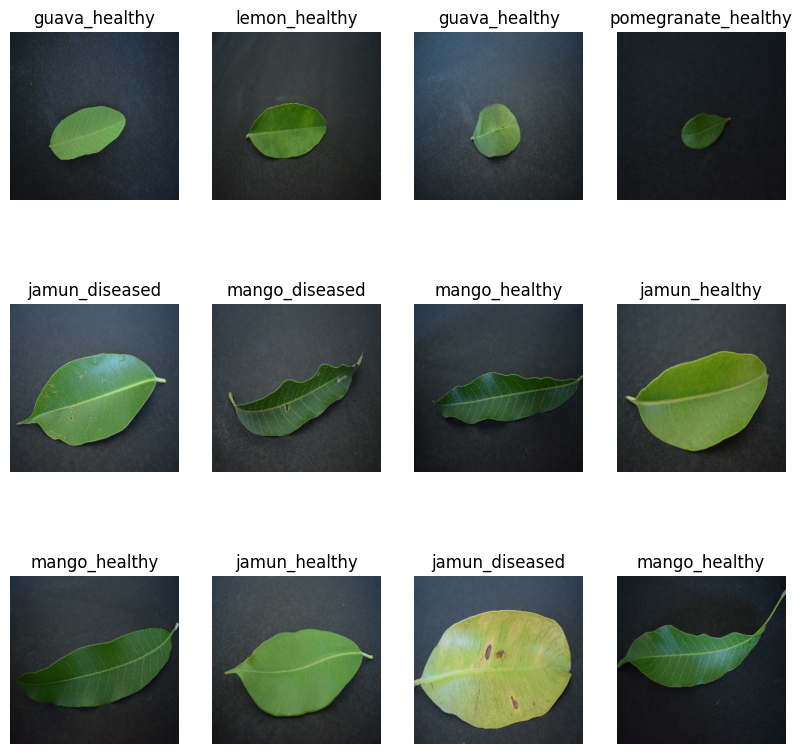

In [28]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [29]:
len(dataset)

72

In [30]:
train_size = 0.8
len(dataset)*train_size

57.6

In [31]:
test_ds = dataset.skip(54)
len(test_ds)

18

In [32]:
val_size=0.1
len(dataset)*val_size

7.2

In [33]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [34]:
test_ds = test_ds.skip(6)
len(test_ds)

12

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

57

In [38]:
len(val_ds)

7

In [39]:
len(test_ds)

8

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [42]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
57/57 [==============================] - 110s 1s/step - loss: 2.0662 - accuracy: 0.2275 - val_loss: 1.6311 - val_accuracy: 0.3527
Epoch 2/50
57/57 [==============================] - 52s 921ms/step - loss: 1.3919 - accuracy: 0.4841 - val_loss: 1.1893 - val_accuracy: 0.5848
Epoch 3/50
57/57 [==============================] - 52s 914ms/step - loss: 1.0629 - accuracy: 0.6091 - val_loss: 0.8789 - val_accuracy: 0.6473
Epoch 4/50
57/57 [==============================] - 52s 922ms/step - loss: 0.9019 - accuracy: 0.6508 - val_loss: 0.8335 - val_accuracy: 0.7054
Epoch 5/50
57/57 [==============================] - 53s 936ms/step - loss: 0.7759 - accuracy: 0.7094 - val_loss: 0.6878 - val_accuracy: 0.7455
Epoch 6/50
57/57 [==============================] - 52s 913ms/step - loss: 0.6667 - accuracy: 0.7462 - val_loss: 0.7204 - val_accuracy: 0.7188
Epoch 7/50
57/57 [==============================] - 50s 885ms/step - loss: 0.6425 - accuracy: 0.7637 - val_loss: 0.6352 - val_accuracy: 0.7723
E

In [47]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 29s 227ms/step - loss: 0.1649 - accuracy: 0.9727


In [48]:
scores

[0.16492818295955658, 0.97265625]

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 57}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
type(history.history['loss'])

list

In [53]:
len(history.history['loss'])

50

In [54]:
history.history['loss'][:5]

[2.066249132156372,
 1.391880750656128,
 1.0629183053970337,
 0.9019384980201721,
 0.7759106159210205]

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

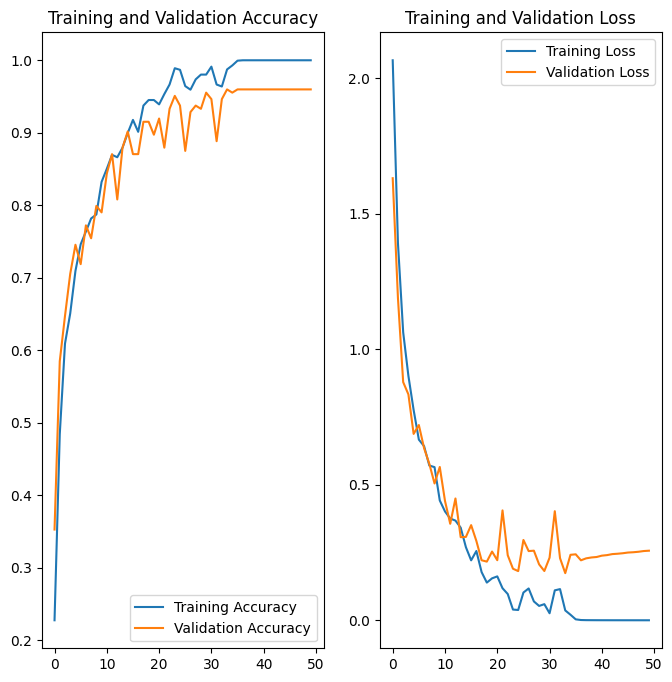

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: pomegranate_diseased
1/1 [==============================] - 0s 237ms/step
predicted label: pomegranate_diseased


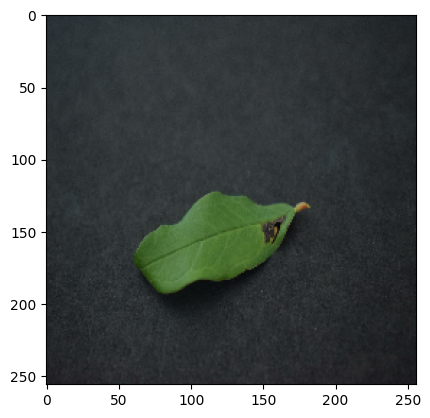

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])